## Where's Wilma?

This notebook implements the CAM algorithm to determine which parts of an image in a fully convolutional network are most responsible for the resulting classification.

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

from skimage.transform import resize

import warnings
warnings.filterwarnings('ignore')

The first step is to have the ability to define a Hook in the model (hook_fn), which allows us to save the output of a layer to a separate variable that we can access later.

In [3]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

The calc_f2 function accepts a single image and then calculates the relative ratio of significance to the final classification

In [4]:
def calc_f2(x):
    x = x[None,0]                                                  #strip off any axis that come with the image
    sfs = [SaveFeatures(o) for o in [m[-7], m[-6], m[-5], m[-4]]]  #define the hooks in the model
    py = m(Variable(x.cuda()))                                     #score the image
    for o in sfs: o.remove()                                       #remove the hooks from the model
    py = np.exp(to_np(py)[0])                                      #convert the prediction back to a percentage
    feat = np.maximum(0,to_np(sfs[3].features[0]))                 #pull the positive features out of the last hook (m[-4])
    f2=np.dot(np.rollaxis(feat,0,3), py)                           #convert the convolutions
    f2-=f2.min()                                                   #subtract the min and divide by the max to force a 0 to 1 scale
    f2/=f2.max()
    return f2

Define a few little functions that make it easier to display the images

In [5]:
def show_raw(x, fig, pos):
    fig.add_subplot(2, 2, pos)
    dx = data.val_ds.denorm(x)[0]
    plt.imshow(dx)
    
def show_raws(x1, x2, x3, x4):
    fig=plt.figure(figsize=(12, 12))
    show_raw(x1, fig, 1)
    show_raw(x2, fig, 2)
    show_raw(x3, fig, 3)
    show_raw(x4, fig, 4)
    plt.show()
    
def hotspot(x, fig, pos):
    fig.add_subplot(2, 2, pos)
    f2 = calc_f2(x)
    dx = data.val_ds.denorm(x)[0]
    plt.imshow(dx)
    plt.imshow(resize(f2, dx.shape), alpha=0.5, cmap='hot') #The convolution output is going to be something smaller than the image, 7x7 in the defaults, so it needs to be resized the stretch over the image
    
def hotspots(x1, x2, x3, x4):
    fig=plt.figure(figsize=(12, 12))
    hotspot(x1, fig, 1)
    hotspot(x2, fig, 2)
    hotspot(x3, fig, 3)
    hotspot(x4, fig, 4)
    plt.show()

Define a few standard variables, feel free to point this notebook at the dogs and cats if you would prefer

In [6]:
#PATH = "/home/ubuntu/data/dogscats/"
PATH = "/home/ubuntu/data/flintstones/"
sz = 224
arch = resnet34
bs = 64

Define the model as a resnet34 pretrained architecture

In [7]:
m = arch(True)

Let's have a look at resnet34:

In [8]:
m

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

The fully connected layer at the end is what makes it difficult to work out which part of the image is important.

We can fix that by dropping the last two layers, using a convolution to convert the 512 channels into two (Wilma / Not Wilma), and then adaptive average pooling / log softmax to calculate the likelihood of each category

In [17]:
m = nn.Sequential(*children(m)[:-2], 
                  nn.Conv2d(512, 2, 3, padding=1), 
                  nn.AdaptiveAvgPool2d(1), 
                  Flatten(), 
                  nn.LogSoftmax())

Now we have our model, let's define the data.

We redefine the image classifier data with a batch size of one to make it easier for us to iterate through the images.

In [19]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)
hotspot_data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=1)
iterator = iter(hotspot_data.val_dl)

Let's have a look at a few images, rerun if you don't like the ones you get.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


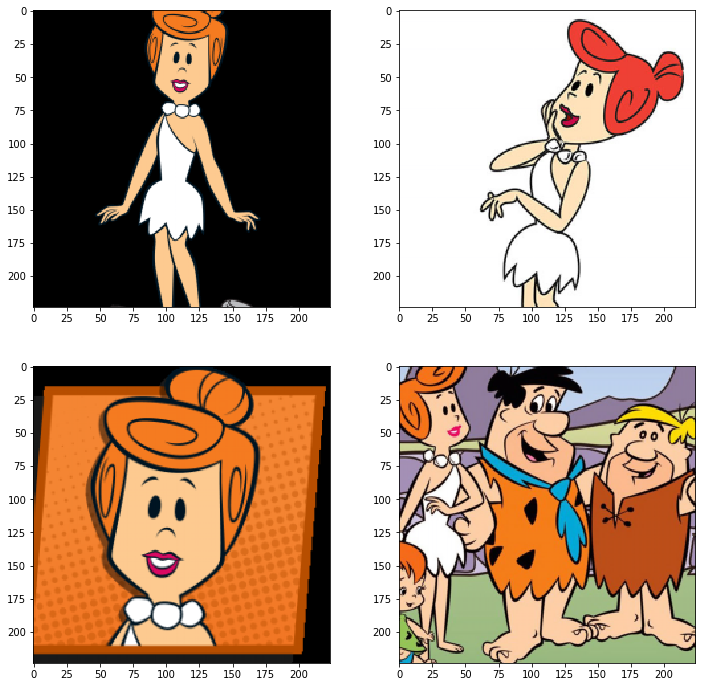

In [11]:
x1,y = next(iterator)
x2,y = next(iterator)
x3,y = next(iterator)
x4,y = next(iterator)

show_raws(x1, x2, x3, x4)

Now we define a learner

In [12]:
learn = ConvLearner.from_model_data(m, data)

and unfreeze it, because The Flintstone's look nothing like imagenet.

In [13]:
learn.unfreeze()

Let's run an epoch and see what the model is looking at.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch      trn_loss   val_loss   accuracy   
    0      3.319933   5.054981   0.716146  



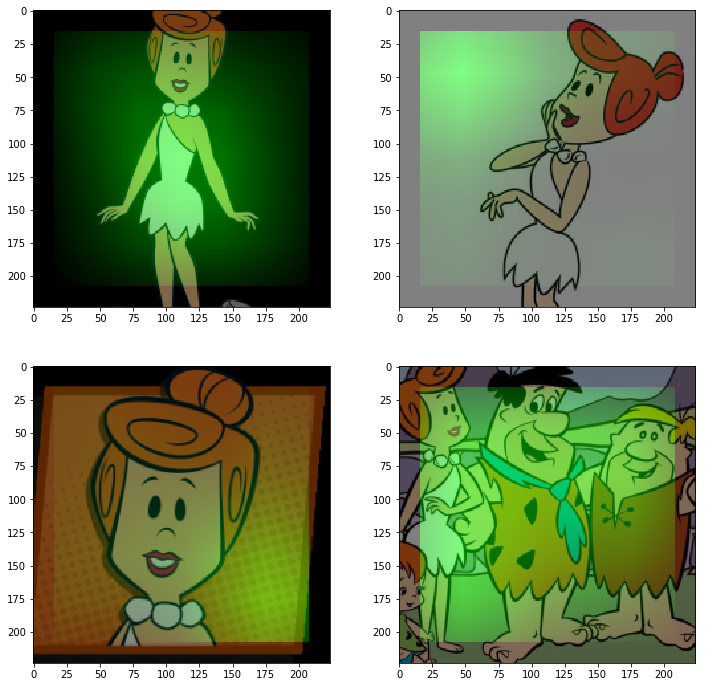

In [14]:
learn.fit(0.01, 1)
hotspots(x1, x2, x3 ,x4)

It's not doing a very good job, yet. Let's have a look at what that last layer actually looks like:

In [15]:
calc_f2(x1)

array([[0.13893, 0.29588, 0.36989, 0.29886, 0.25832, 0.1929 , 0.09013],
       [0.24311, 0.51342, 0.66276, 0.62414, 0.51223, 0.37588, 0.20904],
       [0.21817, 0.5536 , 0.83874, 0.88162, 0.77817, 0.48629, 0.22072],
       [0.17053, 0.49695, 0.87633, 1.     , 0.90201, 0.5455 , 0.21618],
       [0.12875, 0.4082 , 0.75793, 0.93099, 0.86943, 0.53464, 0.2128 ],
       [0.08735, 0.31597, 0.53038, 0.67258, 0.64438, 0.44389, 0.18102],
       [0.     , 0.12658, 0.2354 , 0.26494, 0.26551, 0.18518, 0.06559]], dtype=float32)

If we train a few more epoch we can see that the activations start to line up more closely with Wilma in the images:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch      trn_loss   val_loss   accuracy   
    0      0.740761   0.268089   0.927083  



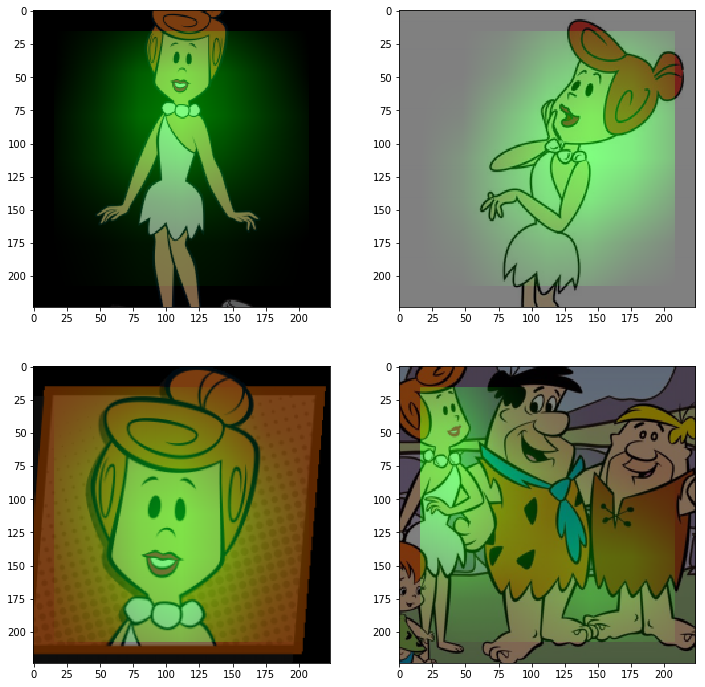

In [16]:
learn.fit(0.01, 1)
hotspots(x1, x2, x3 ,x4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch      trn_loss   val_loss   accuracy   
    0      0.147822   0.834221   0.953125  



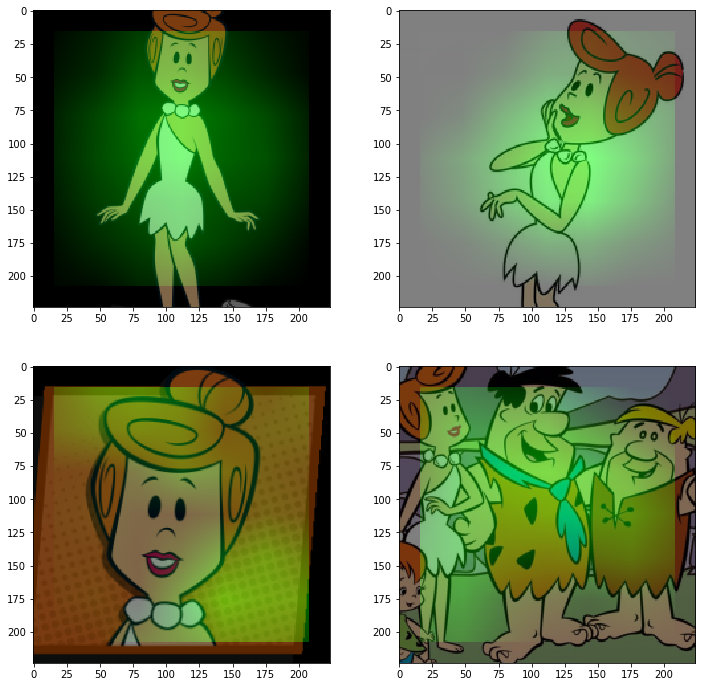

In [15]:
learn.fit(0.01, 1)
hotspots(x1, x2, x3 ,x4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch      trn_loss   val_loss   accuracy   
    0      0.042305   0.489131   0.911458  



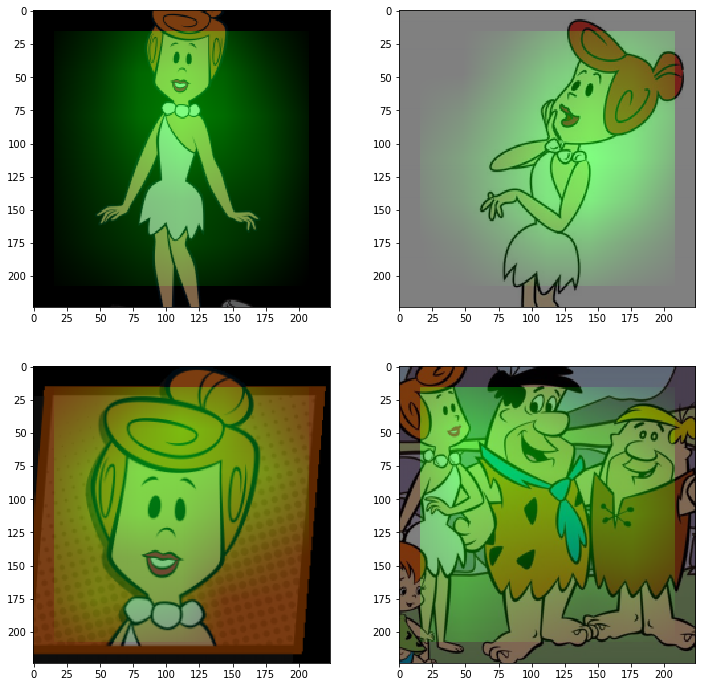

In [16]:
learn.fit(0.01, 1)
hotspots(x1, x2, x3 ,x4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch      trn_loss   val_loss   accuracy   
    0      0.033484   0.471525   0.953125  



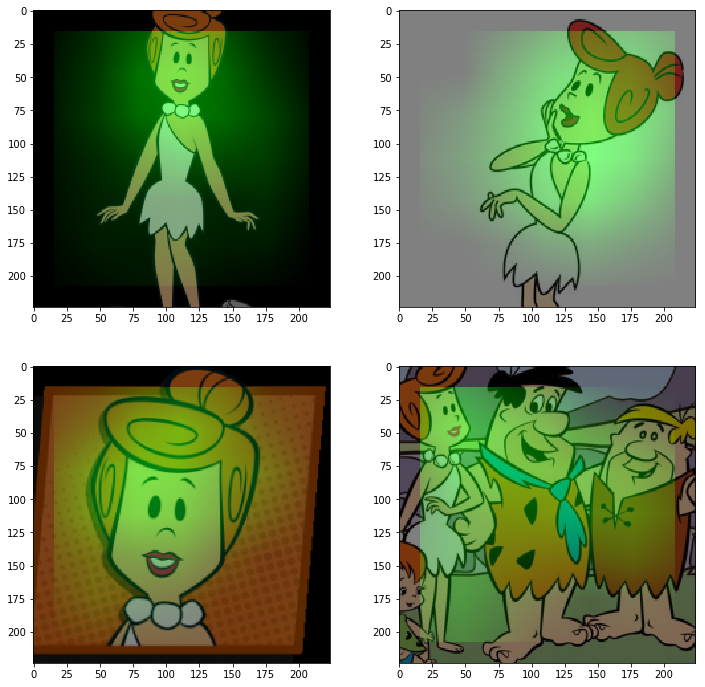

In [17]:
learn.fit(0.01, 1)
hotspots(x1, x2, x3 ,x4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch      trn_loss   val_loss   accuracy   
    0      0.047283   0.701489   0.945312  



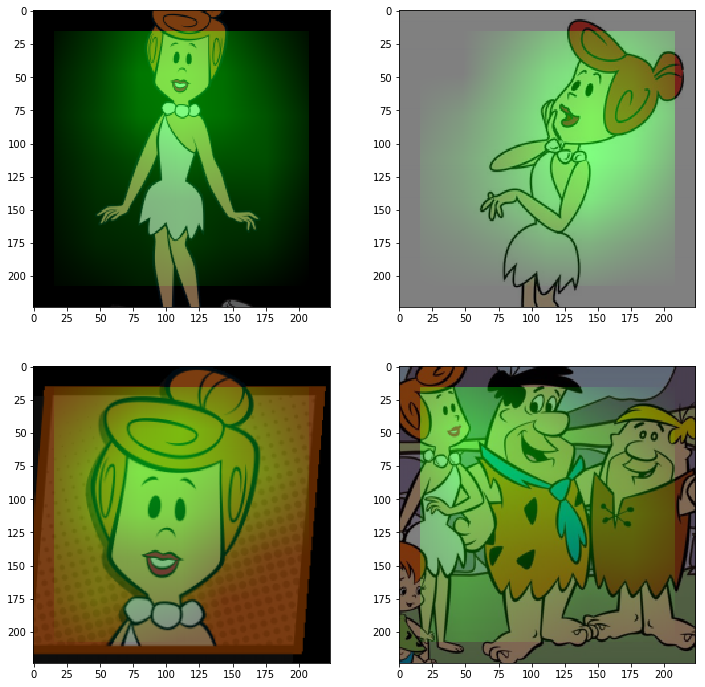

In [18]:
learn.fit(0.01, 1)
hotspots(x1, x2, x3 ,x4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch      trn_loss   val_loss   accuracy   
    0      0.027263   0.276886   0.903646  



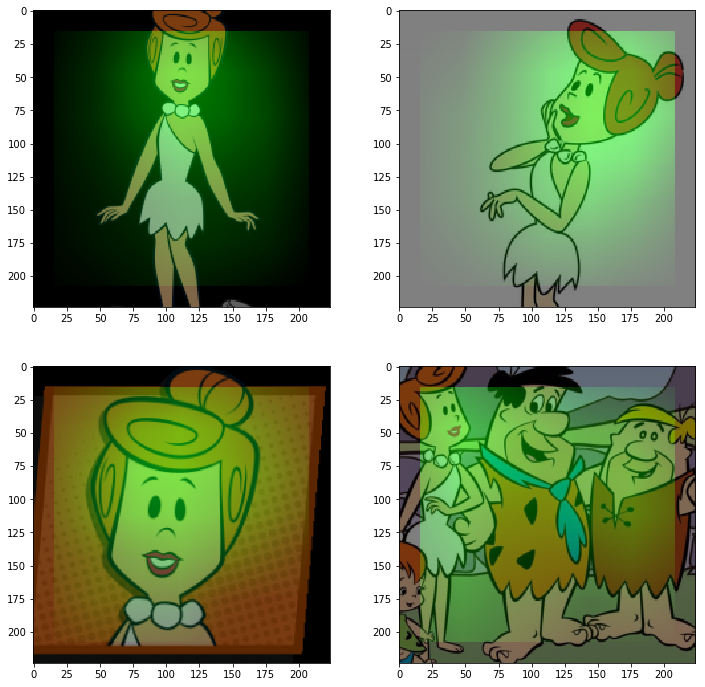

In [19]:
learn.fit(0.01, 1)
hotspots(x1, x2, x3 ,x4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch      trn_loss   val_loss   accuracy   
    0      0.022168   0.296686   0.96875   



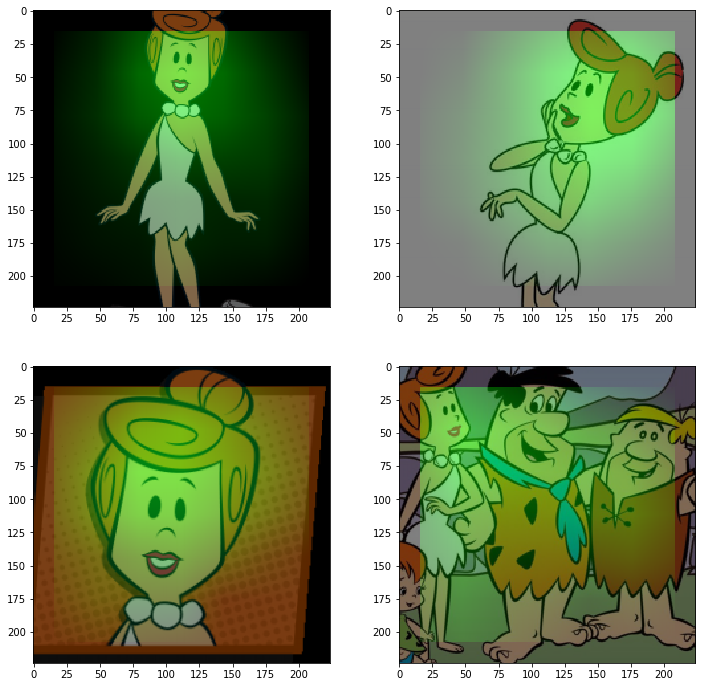

In [20]:
learn.fit(0.01, 1)
hotspots(x1, x2, x3 ,x4)